In [2]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, utils
from skimage import transform
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
import time
import os
import re
import random
from imageio import imread
from pathlib import Path
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import shutil
from torchvision.models import vgg16

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Prepare mini train/valid datasets

In [69]:
p1 = Path('../../../data/nyu/valid')
p2 = Path('../../../data/nyu/mini_valid')

p1r = p1 / 'rgb'
p1d = p1 / 'depth'

p2r = p2 / 'rgb'
p2d = p2 / 'depth'

if os.path.exists(p2r):
    shutil.rmtree(p2r)
os.makedirs(p2r)

if os.path.exists(p2d):
    shutil.rmtree(p2d)
os.makedirs(p2d)

a = os.listdir(p1r)
j = 0
for i in range(0, len(a), 100):
    shutil.copyfile(p1r / '{}.ppm'.format(i), p2r / '{}.ppm'.format(j))
    shutil.copyfile(p1d / '{}.pgm'.format(i), p2d / '{}.pgm'.format(j))
    j += 1
    
print(j, ' images copied.')

694  images copied.


In [4]:
data_dir_train = Path('../../../data/nyu/train')
data_dir_valid = Path('../../../data/nyu/mini_train')

class DepthEigenDataset(Dataset):

    def __init__(self, rgb_dir, depth_dir, transform=None):
        super(DepthEigenDataset, self).__init__()
        
        self.rgb_dir = rgb_dir
        self.depth_dir = depth_dir
        self.transform = transform
        
    def __len__(self):
        return len(os.listdir(self.rgb_dir))
    
    def __getitem__(self, idx):
         
        # read as PIL images
        rgb_sample = Image.open(self.rgb_dir / '{}.ppm'.format(idx))
        depth_sample = Image.open(self.depth_dir / '{}.pgm'.format(idx))
        
        # transform
        seed = random.randint(0, 2 ** 32)
        if self.transform:
            random.seed(seed)
            rgb_sample = self.transform(rgb_sample)
            
            random.seed(seed)
            depth_sample = self.transform(depth_sample)
        
        # resize depth image
        depth_sample = transforms.Resize((74, 55))(depth_sample)
        
        # convert to torch tensor
        rgb_sample = transforms.ToTensor()(rgb_sample)
        depth_sample = transforms.ToTensor()(depth_sample).view(74, 55)
        
        sample = {'rgb':rgb_sample, 'depth': depth_sample}
        
        return sample

trans_train = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomCrop((304, 228)),
    transforms.RandomHorizontalFlip(),
])

trans_test = transforms.Compose([
    transforms.Resize((304, 228)),
])
    
dataset_train = DepthEigenDataset(data_dir_train / 'rgb', data_dir_train / 'depth', transform=trans_train)
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)

dataset_valid = DepthEigenDataset(data_dir_valid / 'rgb', data_dir_valid / 'depth', transform=trans_test)
dataloader_valid = DataLoader(dataset_valid, batch_size=32, shuffle=True)

datalen_train = len(dataset_train)
datalen_valid = len(dataset_valid)

print(datalen_train, datalen_valid)

280613 2807


In [5]:
class GlobalCoarseNet(nn.Module):
    
    def __init__(self):
        super(GlobalCoarseNet, self).__init__()
        
        self.coarse1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        self.coarse2 = nn.Sequential(nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2), 
                                     nn.ReLU(),
                                     nn.MaxPool2d(kernel_size=2))
        
        self.coarse3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse4 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1), 
                                     nn.ReLU())
        
        self.coarse5 = nn.Sequential(nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=2), 
                                     nn.ReLU())
        
        self.coarse6 = nn.Sequential(nn.Linear(in_features=256 * 8 * 6, out_features=4096), 
                                     nn.ReLU(), nn.Dropout(0.5))
        
        self.coarse7 = nn.Linear(in_features=4096, out_features=74 * 55)
        
    
    def forward(self, x):
        x = self.coarse1(x)
        x = self.coarse2(x)
        x = self.coarse3(x)
        x = self.coarse4(x)
        x = self.coarse5(x)
        x = x.reshape(x.size(0), -1)
        x = self.coarse6(x)
        x = self.coarse7(x)
        x = x.reshape(x.size(0), 74, 55)
        return x

class LocalFineNet(nn.Module):
    
    def __init__(self):
        super(LocalFineNet, self).__init__()
        
        self.fine1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=63, kernel_size=9, stride=2),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2))
        
        self.fine2 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, padding=2), 
                                   nn.ReLU())
        
        self.fine3 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=5, padding=2)
    
    def forward(self, x, global_output_batch):
        x = self.fine1(x)
        x = torch.cat((x, global_output_batch), dim=1)
        x = self.fine2(x)
        x = self.fine3(x)
        
        return x

In [6]:
global_model = torch.load('./models/global_model.pt')
global_model.eval()

local_model = torch.load('./models/local_model.pt')
local_model.eval()

DataParallel(
  (module): LocalFineNet(
    (fine1): Sequential(
      (0): Conv2d(3, 63, kernel_size=(9, 9), stride=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(63, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fine2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (fine3): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [7]:
for i, samples in enumerate(dataloader_valid):

    rgbs = samples['rgb'].float().to(device)
    depths = samples['depth'].float().to(device)

    # results from global coarse network
    with torch.no_grad():
        global_output = global_model(rgbs).unsqueeze(1)
        #global_output = torch.exp(global_output)
    
    # results from local fine network
    local_model.eval()
    with torch.no_grad():
        local_output = local_model(rgbs, global_output)

    break

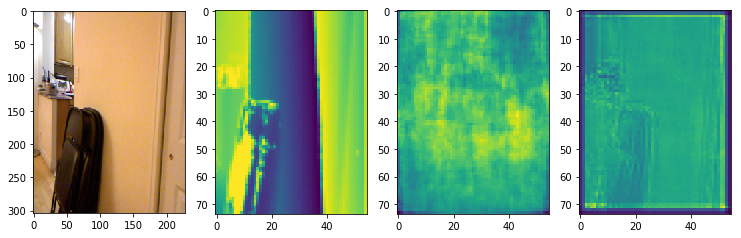

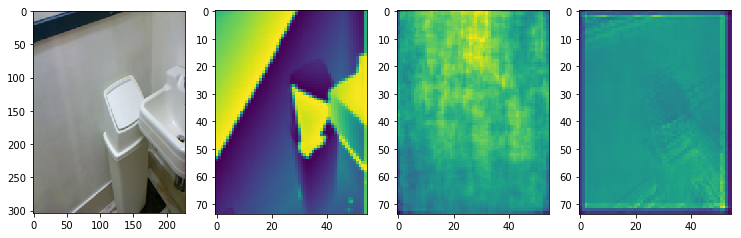

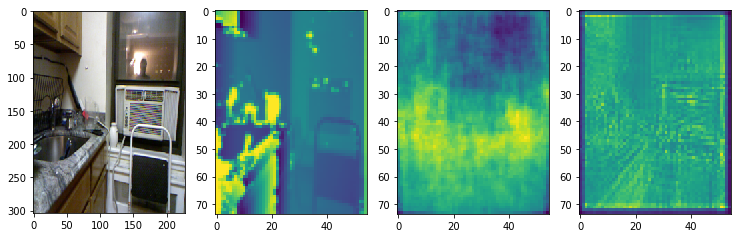

In [8]:
figsize(12.5, 4)

for i in range(3):

    dg = global_output[i].view(74, 55)
    dl = local_output[i].view(74, 55)
    r = transforms.ToPILImage()(rgbs[i].cpu())
    d_true = depths[i]
    
    plt.subplot(141)
    plt.imshow(r)
    
    plt.subplot(142)
    plt.imshow(d_true.cpu())
    
    plt.subplot(143)
    plt.imshow(torch.exp(dg).cpu())
    
    plt.subplot(144)
    plt.imshow(torch.exp(dl).cpu())

    plt.show()

(array([2.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 1.600e+01,
        2.600e+01, 2.200e+01, 9.000e+00, 5.000e+00, 1.800e+01, 4.000e+01,
        4.800e+01, 1.300e+01, 2.000e+00, 3.000e+00, 3.600e+01, 7.200e+01,
        1.140e+02, 5.000e+01, 1.100e+01, 3.400e+01, 2.590e+02, 7.710e+02,
        1.225e+03, 8.100e+02, 3.540e+02, 1.000e+02, 2.200e+01, 5.000e+00]),
 array([0.39592463, 0.48641053, 0.5768964 , 0.6673823 , 0.75786823,
        0.8483541 , 0.93884003, 1.029326  , 1.1198118 , 1.2102977 ,
        1.3007836 , 1.3912694 , 1.4817554 , 1.5722413 , 1.6627272 ,
        1.753213  , 1.843699  , 1.9341849 , 2.0246708 , 2.1151567 ,
        2.2056425 , 2.2961285 , 2.3866143 , 2.4771001 , 2.5675862 ,
        2.658072  , 2.748558  , 2.8390439 , 2.9295297 , 3.0200157 ,
        3.1105015 ], dtype=float32),
 <a list of 30 Patch objects>)

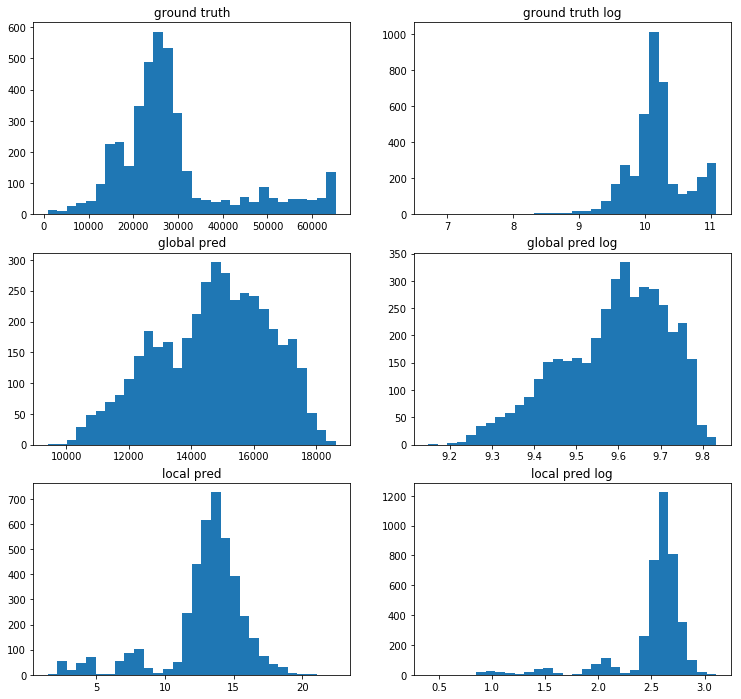

In [9]:
figsize(12.5, 12)

plt.subplot(321)
plt.title('ground truth')
plt.hist(d_true.cpu().view(-1), bins=30)

plt.subplot(322)
plt.title('ground truth log')
plt.hist(torch.log(d_true.cpu().view(-1)), bins=30)

plt.subplot(323)
plt.title('global pred')
plt.hist(torch.exp(dg).cpu().view(-1), bins=30)

plt.subplot(324)
plt.title('global pred log')
plt.hist(dg.cpu().view(-1), bins=30)

plt.subplot(325)
plt.title('local pred')
plt.hist(torch.exp(dl).cpu().view(-1), bins=30)

plt.subplot(326)
plt.title('local pred log')
plt.hist(dl.cpu().view(-1), bins=30)